## Objectives

* Answer business requirement one:
  * The client wishes us to conduct an analysis of current elite-level golf tournament data 
    to determine which golfing skills (e.g., driving, approach play, chipping, and putting) 
    are most likely to result in a player reaching the top ten of a tournament. 
    They are specifically interested in learning which skill to focus on to help a player 
    improve from a 30th–11th place finish to a top-ten finish.

## Inputs

* outputs\data\final\ cleaned_golfdata.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build the StreamLit App.



# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics'

## Load the Data Frame

In [4]:
import pandas as pd

df = pd.read_csv(r'outputs\data\final\cleaned_golfdata.csv')

print(df.head())


   player_id  tournament_id  finish_numeric  true_pos  top_ten  mid_band  \
0       9261      401353224            32.0      32.0        0         0   
1       5548      401353224            18.0      18.0        0         1   
2       4989      401353224             0.0      91.0        0         0   
3       6015      401353224             0.0      91.0        0         0   
4       3832      401353224             0.0      91.0        0         0   

   sg_putt  sg_arg  sg_app  sg_ott  sg_t2g  sg_total  
0     0.20   -0.13   -0.08    0.86    0.65      0.85  
1     0.36    0.75    0.31    0.18    1.24      1.60  
2    -0.56    0.74   -1.09    0.37    0.02     -0.54  
3    -1.46   -1.86   -0.02    0.80   -1.08     -2.54  
4     0.53   -0.36   -1.39    0.19   -1.56     -1.04  


## Analyse average strokes gained data for top_ten vs not top_ten finishers.

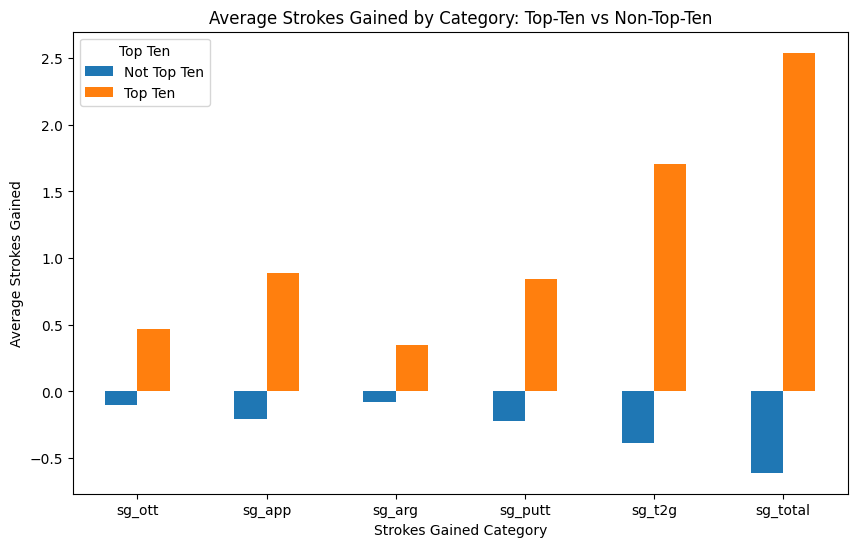

In [6]:
import matplotlib.pyplot as plt

sg_features = ['sg_ott', 'sg_app', 'sg_arg', 'sg_putt', 'sg_t2g', 'sg_total']

avg_sg = df.groupby('top_ten')[sg_features].mean()

avg_sg.T.plot(kind='bar', figsize=(10,6))
plt.title('Average Strokes Gained by Category: Top-Ten vs Non-Top-Ten')
plt.xlabel('Strokes Gained Category')
plt.ylabel('Average Strokes Gained')
plt.xticks(rotation=0)
plt.legend(title='Top Ten', labels=['Not Top Ten', 'Top Ten'])
plt.show()



Next check the differences for each strokes gained stat between a top ten player and a not top ten player.

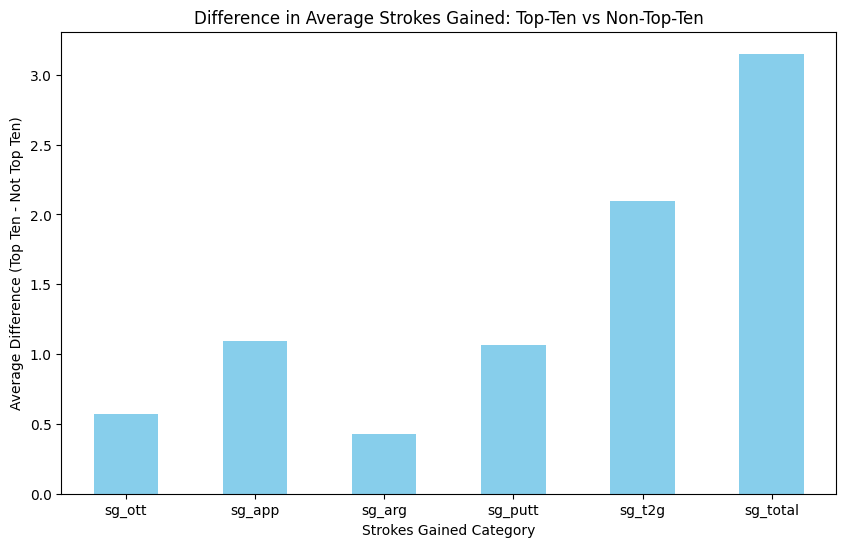

In [8]:
diff_sg = avg_sg.loc[1] - avg_sg.loc[0]

plt.figure(figsize=(10,6))
diff_sg.plot(kind='bar', color='skyblue')
plt.title('Difference in Average Strokes Gained: Top-Ten vs Non-Top-Ten')
plt.xlabel('Strokes Gained Category')
plt.ylabel('Average Difference (Top Ten - Not Top Ten)')
plt.xticks(rotation=0)
plt.show()

It is not a surprise that 'strokes gained total' and 'strokes gained tee to green' dominate in the above plots. They are statistics that combine multiple shot types and will therefore certainly have a bigger impact. Disregarding them, putting and approach play seem to be the biggest indicators of successful golf that is likely to produce a top ten finish.

A pairplot can be used to visualise pairwise relationships between strokes gained features.

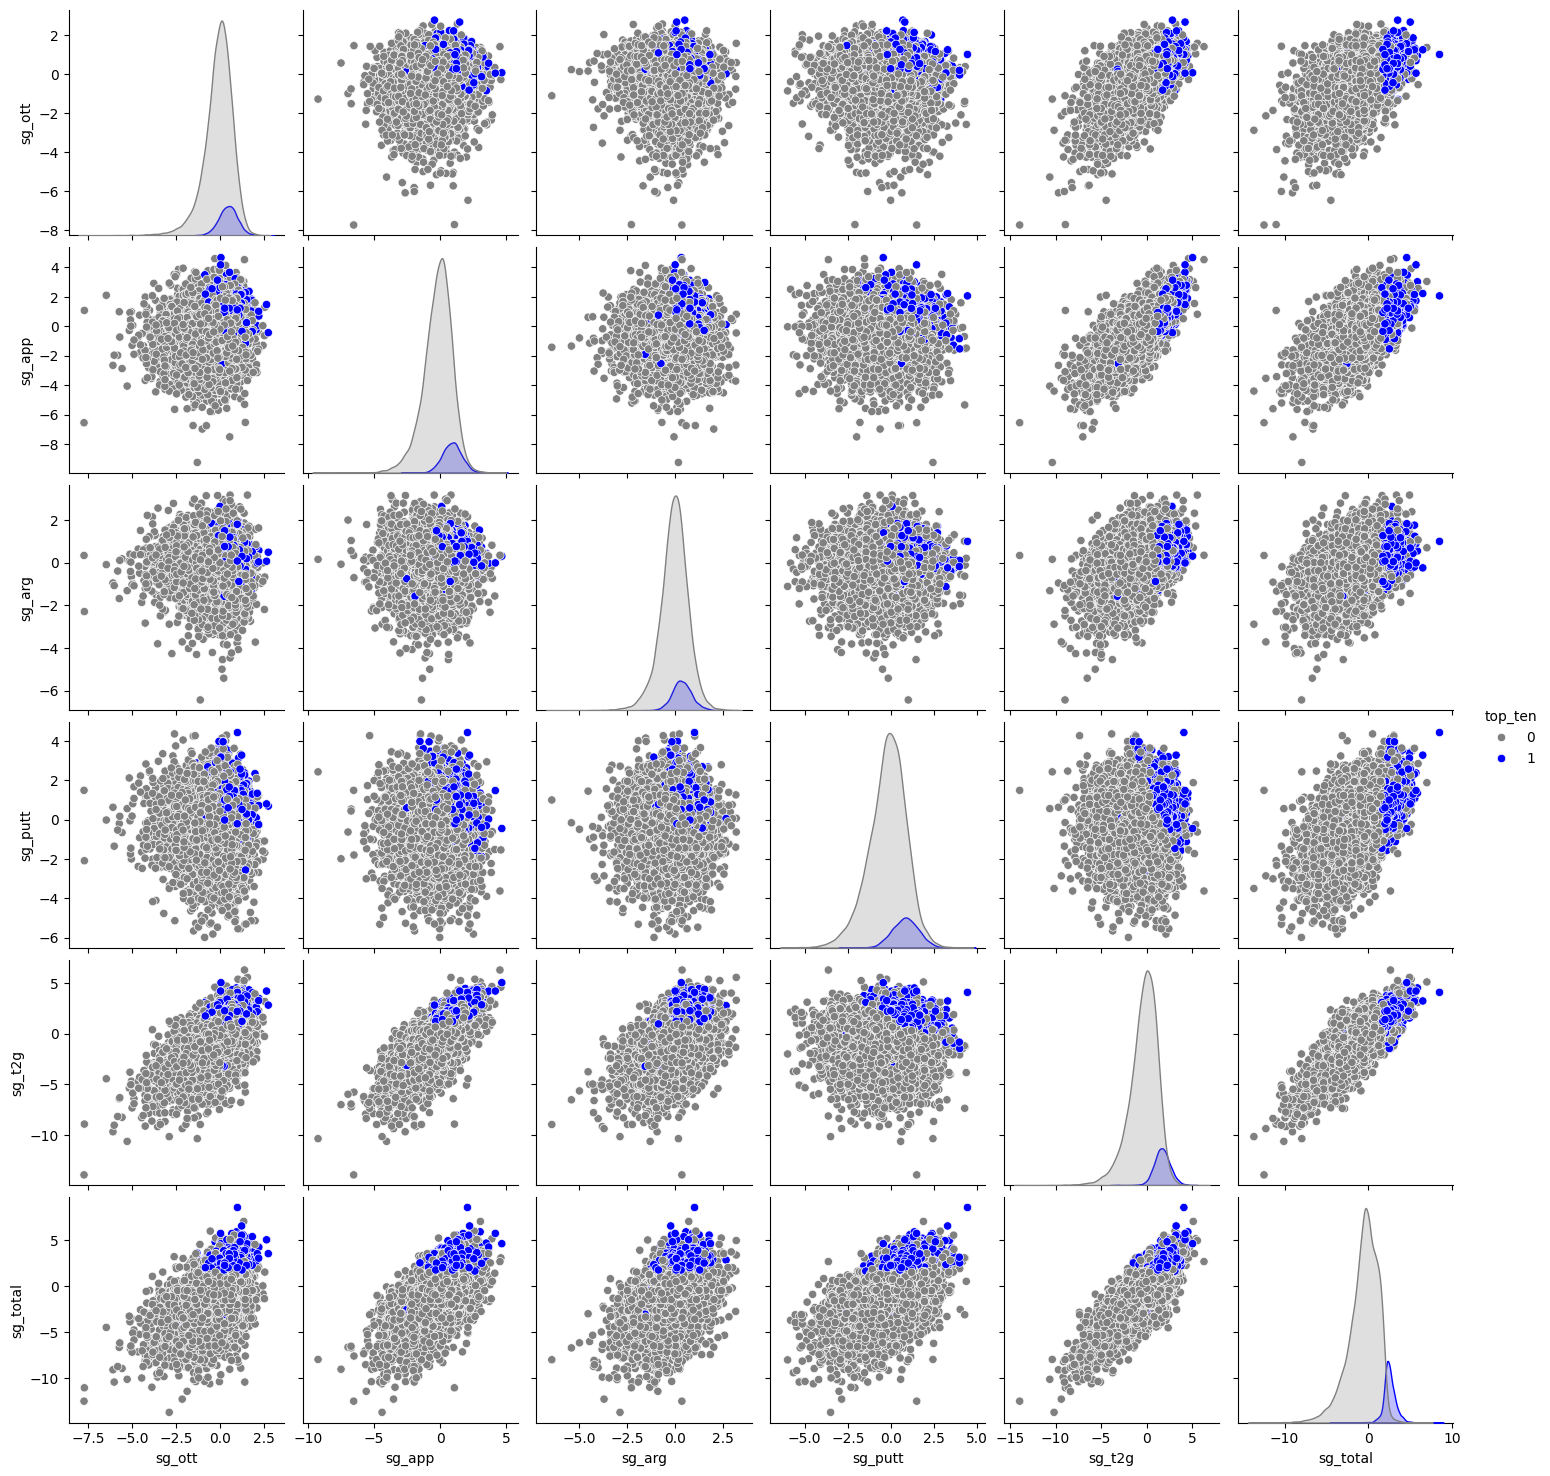

In [10]:
import seaborn as sns

sns.pairplot(df[sg_features + ['top_ten']], hue='top_ten', palette=['grey','blue'])
plt.show()


This indicates that, in general, all strokes gained stastics are important in a high level golf performance. However, there are some examples where a particularly good performance in one area can counteract a slightly negative performance in another, such as the comparison between 'approach' and 'putting'.

## Heatmaps to analyse correlations with different features and a top ten finish.

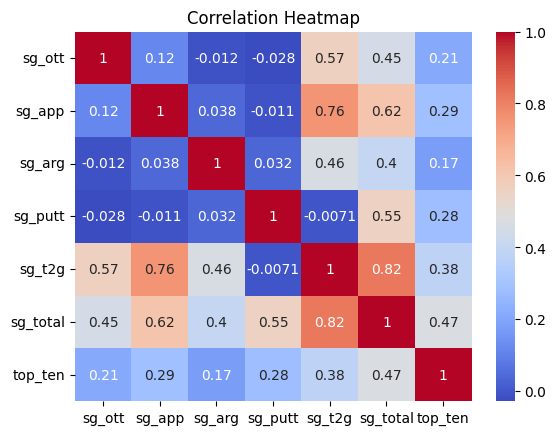

In [12]:
sns.heatmap(df[sg_features + ['top_ten']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Higher correlations between strokes gained stats and top_ten were expected. On reflection, the binary nature of the 'top_ten' data has create issues in that players who finished just outside the top ten would still have very similar strokes gained stats and are skewing the data. Also, a Pearson correlation method was used and strokes gained data is irregular and non-linear, a Spearman correlation may be a better solution.

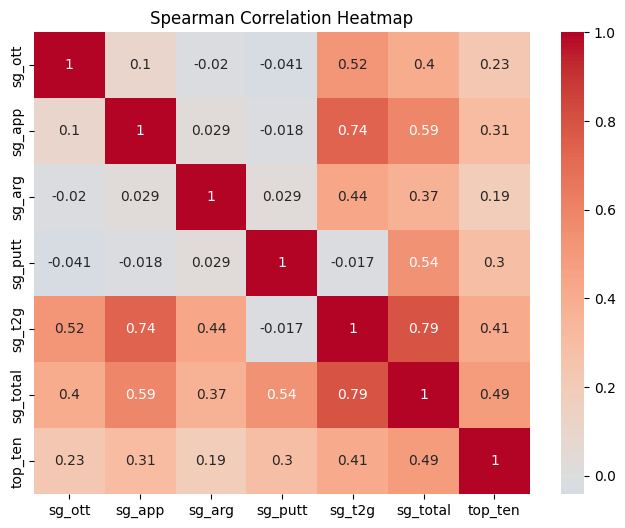

In [13]:
corr_spearman = df[sg_features + ['top_ten']].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap')
plt.show()


A Spearman correlation showed slightly stronger relationships between the strokes gained metrics and top-ten finishes; however, the binary nature of the ‘top_ten’ variable still introduces a degree of noise into the analysis. A Spearman correlation heatmap comparing the strokes gained statistics to a true positive indicator (e.g., 'true_pos') may provide a more effective way to visualise and interpret these relationships.

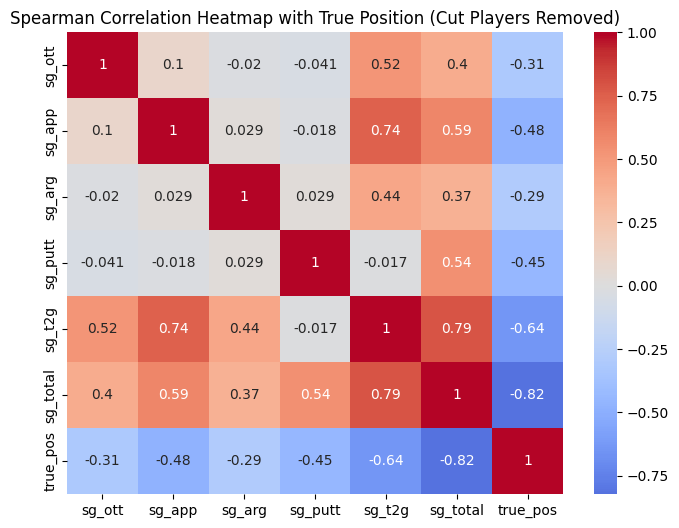

In [ ]:
corr_spearman = df[sg_features + ['true_pos']].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap with True Position')
plt.show()



This now does show a somewhat more significant relationship between strokes gained and finishing position in tournaments. 
Across all these plots, conclusions can be reached that approach play and putting are the biggest factors in determining top ten finishes.
However, overall the correlations between the strokes gained metrics and good tournament finishes remain relatively weak, reflecting the multi-faceted nature of golf performance. Tournament outcomes are influenced by a combination of technical skills, course conditions, mental factors, and variability across rounds, making it difficult for any single metric to show strong predictive power. This must be emphasised to the client.

## Highlighting players who are currently finishing 30-11th and wish to improve to the top 10.

The client specifically requested information on players who are currently finishing between 30th and 11th on a regular basis and wish to improve to reach the top ten and the next plots shall analyse that.
First, to extract groups of 'top ten- elite players, and 'mid-level' players.

In [21]:
top_players = (
    df.groupby('player_id')
    .agg(
        top_ten_finishes=('top_ten', 'sum'),
        avg_sg_putt=('sg_putt', 'mean'),
        avg_sg_arg=('sg_arg', 'mean'),
        avg_sg_app=('sg_app', 'mean'),
        avg_sg_ott=('sg_ott', 'mean'),
        avg_sg_t2g=('sg_t2g', 'mean'),
        avg_sg_total=('sg_total', 'mean')
    )
    .reset_index()
)

top_15_players = top_players.sort_values(by='top_ten_finishes', ascending=False).head(15)

print(top_15_players)



     player_id  top_ten_finishes  avg_sg_putt  avg_sg_arg  avg_sg_app  \
231       4848                54    -0.029225    0.258217    0.646512   
168       3448                51     0.163519    0.053056    0.419630   
365       9780                46     0.249022    0.136630    0.370109   
246       5467                39     0.241746    0.296667    0.308571   
172       3470                38    -0.042683    0.195854    0.432073   
130       1614                35     0.076777    0.337273    0.498678   
372      10046                34     0.048173   -0.013654    0.152019   
153       2230                34    -0.123557    0.107852    0.290201   
5           72                33    -0.091600   -0.020200    0.659800   
299       6798                32     0.138468    0.027928    0.135946   
329       9025                32     0.081069   -0.071145    0.416260   
270       5860                32    -0.258889    0.194444    0.681270   
279       6007                32     0.129643    0.

In [30]:
sg_features_avg = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

player_counts = df['player_id'].value_counts()
eligible_players = player_counts[player_counts >= 20].index
df_eligible = df[df['player_id'].isin(eligible_players)]

mid_band_stats = (
    df_eligible.groupby('player_id')
    .agg(
        total_tournaments=('true_pos', 'count'),
        mid_band_finishes=('true_pos', lambda x: ((x >= 11) & (x <= 30)).sum()),
        avg_sg_putt=('sg_putt', 'mean'),
        avg_sg_arg=('sg_arg', 'mean'),
        avg_sg_app=('sg_app', 'mean'),
        avg_sg_ott=('sg_ott', 'mean'),
        avg_sg_t2g=('sg_t2g', 'mean'),
        avg_sg_total=('sg_total', 'mean')
    )
    .reset_index()
)

mid_band_stats['mid_band_pct'] = mid_band_stats['mid_band_finishes'] / mid_band_stats['total_tournaments'] * 100

top_15_mid_players = mid_band_stats.sort_values(by='mid_band_pct', ascending=False).head(15).reset_index(drop=True)

print(top_15_mid_players)






    player_id  total_tournaments  mid_band_finishes  avg_sg_putt  avg_sg_arg  \
0        9931                 25                 10     0.021600   -0.004000   
1        9243                 30                 12     0.517000    0.131000   
2        5579                136                 52     0.376250    0.267647   
3        5860                126                 47    -0.258889    0.194444   
4        1293                 87                 31     0.120460    0.152299   
5       10140                 96                 34     0.235521    0.025729   
6     4364873                 54                 19     0.058148   -0.391296   
7        5553                 66                 23     0.180152    0.128333   
8       10906                 23                  8    -0.127391   -0.007826   
9        6007                 84                 28     0.129643    0.216548   
10       9126                105                 32    -0.456476   -0.170667   
11      11382                 99        

We need to ensure that there is no overlap between elite players and mid-range players for the data to be a success.

In [31]:
top_ten_ids = top_15_players['player_id'].tolist()

top_15_mid_players_filtered = top_15_mid_players[
    ~top_15_mid_players['player_id'].isin(top_ten_ids)
].copy()

num_needed = 15 - top_15_mid_players_filtered.shape[0]

remaining_players = mid_band_stats[
    ~mid_band_stats['player_id'].isin(
        top_ten_ids + top_15_mid_players_filtered['player_id'].tolist()
    )
].sort_values(by='mid_band_pct', ascending=False)

top_15_mid_players_final = pd.concat(
    [top_15_mid_players_filtered, remaining_players.head(num_needed)],
    ignore_index=True
)

top_15_mid_players_final = top_15_mid_players_final.reset_index(drop=True)

print(top_15_mid_players_final)


    player_id  total_tournaments  mid_band_finishes  avg_sg_putt  avg_sg_arg  \
0        9931                 25                 10     0.021600   -0.004000   
1        9243                 30                 12     0.517000    0.131000   
2        5579                136                 52     0.376250    0.267647   
3        1293                 87                 31     0.120460    0.152299   
4       10140                 96                 34     0.235521    0.025729   
5     4364873                 54                 19     0.058148   -0.391296   
6        5553                 66                 23     0.180152    0.128333   
7       10906                 23                  8    -0.127391   -0.007826   
8        9126                105                 32    -0.456476   -0.170667   
9       11382                 99                 30     0.210808    0.110505   
10       5539                 66                 20     0.022273    0.263939   
11       9513                102        

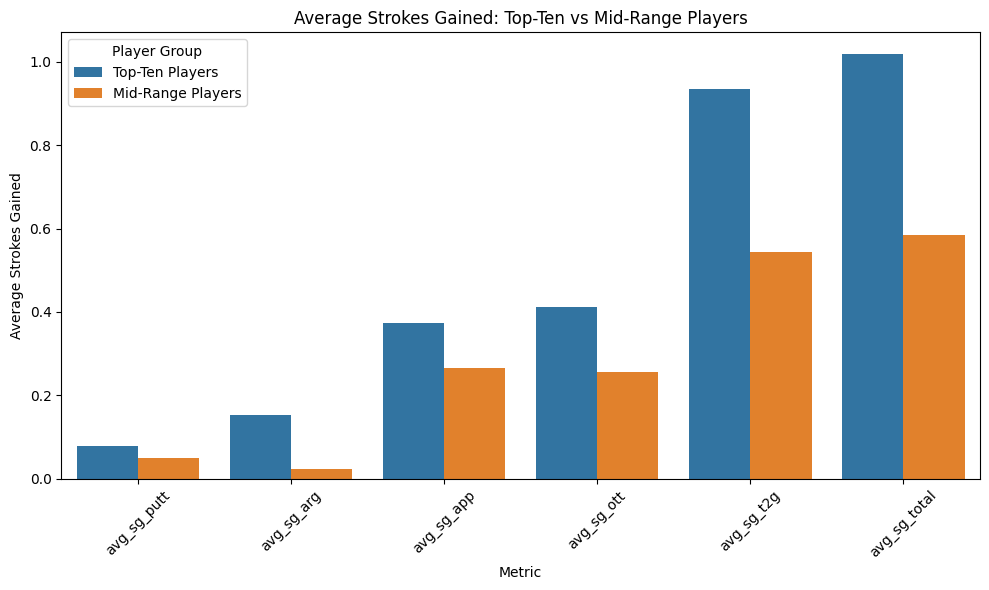

In [32]:
sg_features_avg = ['avg_sg_putt', 'avg_sg_arg', 'avg_sg_app', 'avg_sg_ott', 'avg_sg_t2g', 'avg_sg_total']

plot_df = pd.DataFrame({
    'Strokes Gained Metric': sg_features_avg,
    'Top-Ten Players': top_15_players[sg_features_avg].mean().values,
    'Mid-Range Players': top_15_mid_players_final[sg_features_avg].mean().values
})

plot_df_melted = plot_df.melt(
    id_vars='Strokes Gained Metric', 
    var_name='Player Group', 
    value_name='Average SG'
)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Strokes Gained Metric', 
    y='Average SG', 
    hue='Player Group', 
    data=plot_df_melted
)
plt.title('Average Strokes Gained: Top-Ten vs Mid-Range Players')
plt.ylabel('Average Strokes Gained')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.legend(title='Player Group')
plt.tight_layout()
plt.show()



C:\Users\dmiln\AppData\Local\Temp\ipykernel_18160\830425436.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


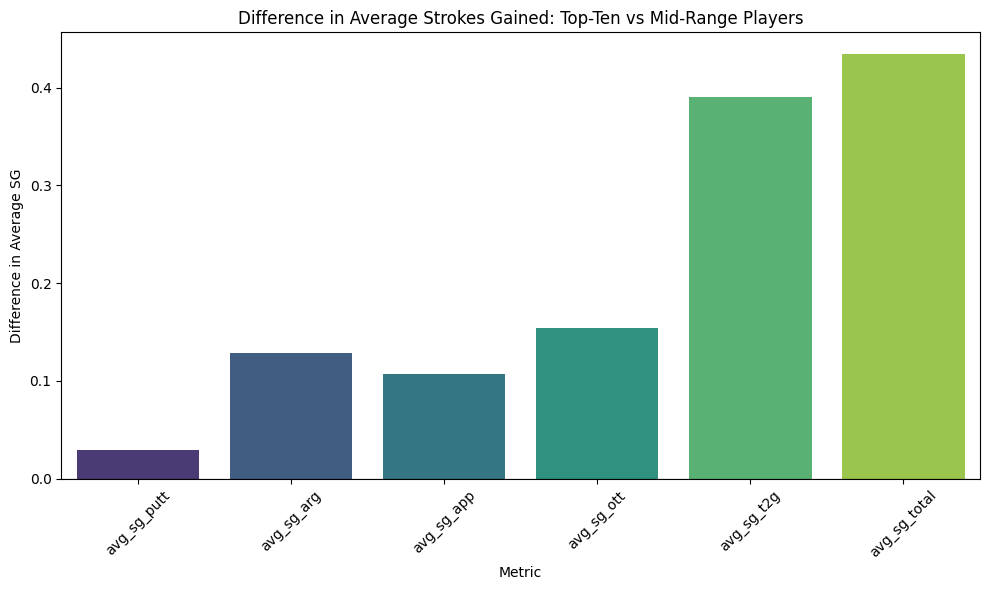

In [34]:
top_ten_avg = top_15_players[sg_features_avg].mean()
mid_avg = top_15_mid_players_final[sg_features_avg].mean()

diff = top_ten_avg - mid_avg

diff_df = pd.DataFrame({
    'Strokes Gained Metric': sg_features_avg,
    'Difference (Top-Ten - Mid-Range)': diff.values
})

plt.figure(figsize=(10,6))
sns.barplot(
    x='Strokes Gained Metric', 
    y='Difference (Top-Ten - Mid-Range)', 
    data=diff_df, 
    palette='viridis'
)
plt.title('Difference in Average Strokes Gained: Top-Ten vs Mid-Range Players')
plt.ylabel('Difference in Average SG')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()



Interestingly. these results are in stark contrast to the previous set analysing all golfers. For those already at a a level to perform to a standard to regularly finish 11-30th, it would appear the skills of chipping (around the green) and driving (off the tee) are the most in need of development. This suggests that targeted development in these specific skills could help mid-range players bridge the gap to top-ten performance.

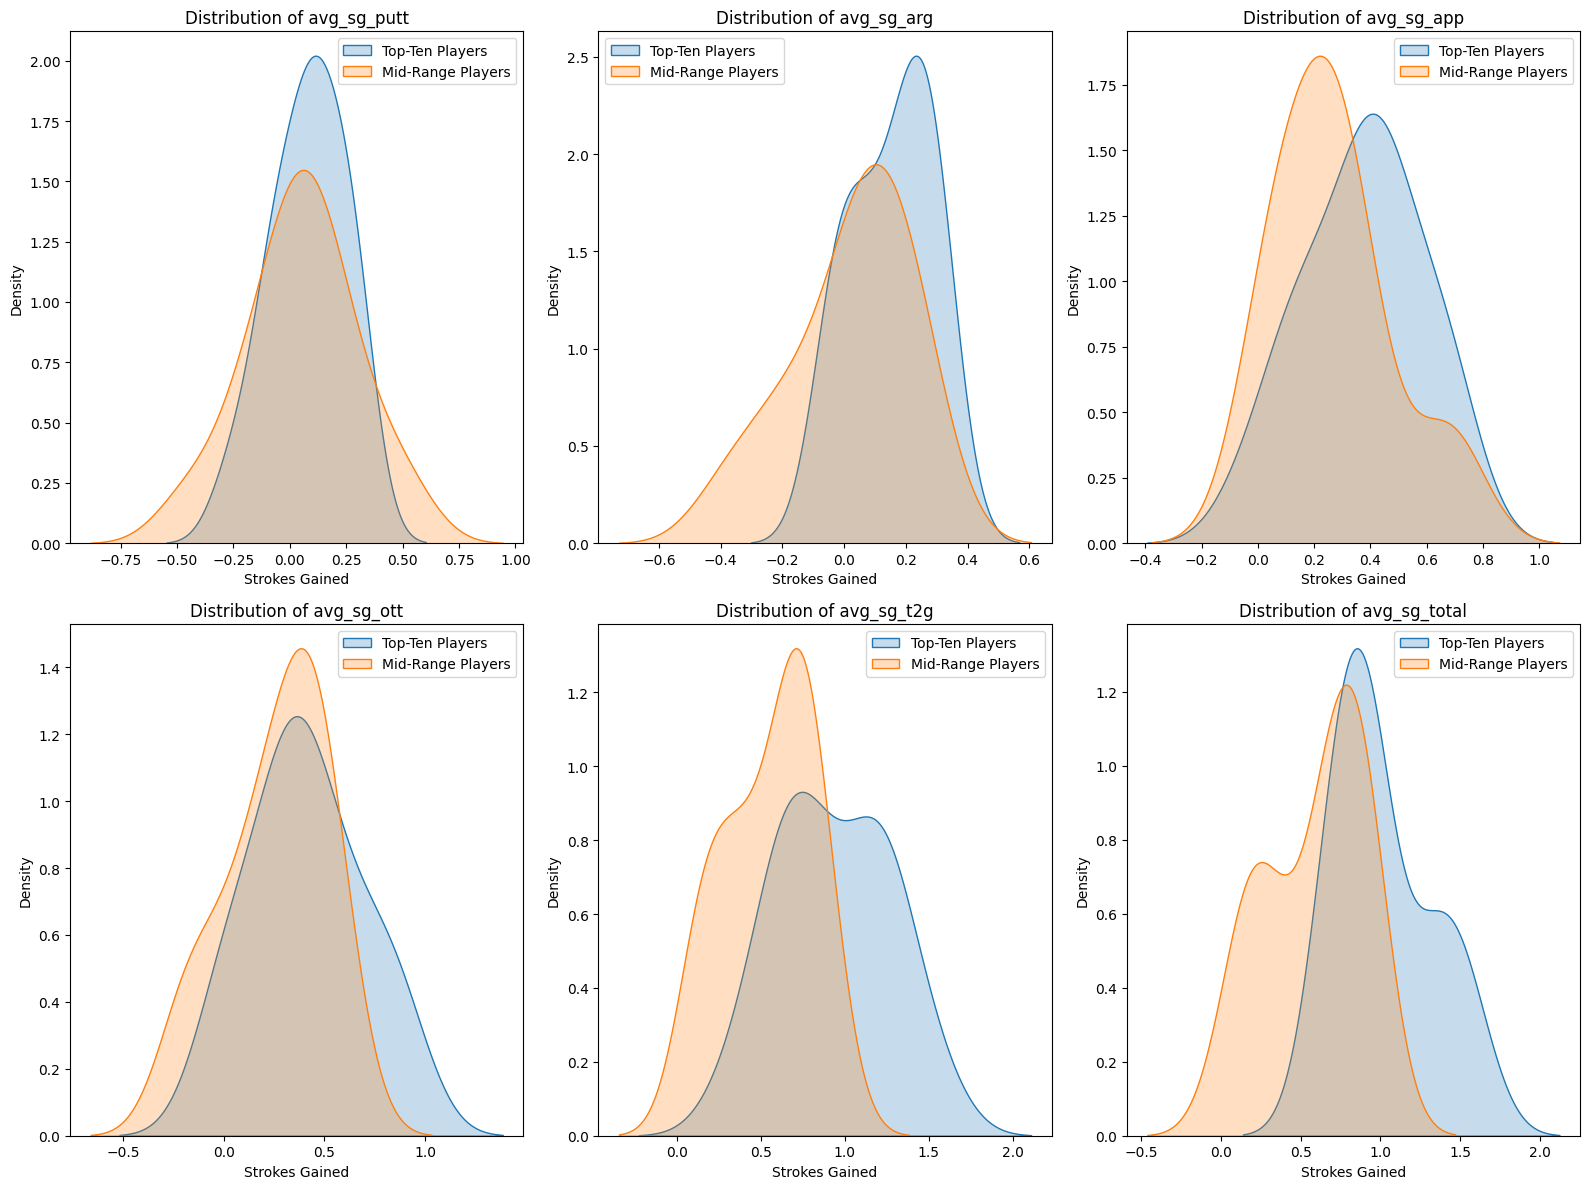

In [36]:
plt.figure(figsize=(16, 12))

for i, metric in enumerate(sg_features_avg, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(top_15_players[metric], label='Top-Ten Players', fill=True)
    sns.kdeplot(top_15_mid_players_final[metric], label='Mid-Range Players', fill=True)
    plt.title(f'Distribution of {metric}')
    plt.xlabel('Strokes Gained')
    plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout()
plt.show()




The KDE plot further emphasises the difference in the 'around the green' metric for elite players in comparison to mid-range players. A Number of mid-range players even slip into negative around the green statistics, whereas elite players are all of a very similar standard of performance. 

## Conclusions and Next Steps ##

- Approach Play and Putting are the factors most correlated with top-ten performance. This contradicts Hypothesis 1 and will be communicated to the client.

- Chipping and Driving show the largest differential between mid-range golfers (regularly finishing 11th–30th) and elite golfers (regularly finishing in the top ten). This contradicts Hypothesis 2 and will be communicated to the client.

- No single strokes gained skill shows a very strong correlation with top-ten finishes or good tournament finishes in general, which aligns with Hypothesis 3.

- Further analyses using feature importance and model coefficients will be conducted during the machine learning stage to provide more robust answers to all business requirements.

- Next, feature engineering will be undertaken to prepare the dataset for machine learning.